### **This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957 to August 7th 2020.**

### Import Statements

In [202]:
%pip install country_converter --upgrade

Note: you may need to restart the kernel to use updated packages.


In [203]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco
import datetime

### Load the Data

In [204]:
df_data = pd.read_csv('mission_launches.csv')

Displaying float variables:

In [205]:
pd.options.display.float_format = '{:,.2f}'.format

## Preliminary Data Exploration

Shape of the dataframe:

In [206]:
shape = df_data.shape
print(f"rows: {shape[0]}")
print(f"columns: {shape[1]}")

rows: 4324
columns: 9


Columns of the dataframe:

In [207]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    4324 non-null   int64 
 1   Unnamed: 0      4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


In [208]:
df_data.head()

,Unnamed: 0.1,Unnamed: 0,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [209]:
print(f"any duplicates: {df_data.duplicated().values.any()}")

any duplicates: False


- there are a total of 9 columns in this dataframe
- the first two "Unnamed"-columns seem to be redundant
- for displaying Choroplath maps the ``Location`` has to be converted to the ISO-country codes
- the ``Date`` is just a simple object not a Datetime-object
- the ``Price`` column contains NaN
- there are no duplicated values

## Data Cleaning & Preparation

**I will create a new Dataframe without any NaN values. This will only affect charts and analysis where the ``Price``-column is used. For everything else the cleaned original DataFrame will be used.**

Clean original dataframe:
- [ ] drop the first 2 columns
- [ ] convert the entries in the Date column to Datetime-objects
- [ ] add a column for the ISO-country codes

In [210]:
# Drop the frist 2 columns
df_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

# convert the entries in the Date column to Datetime-objects
df_data.Date = pd.to_datetime(df_data.Date, utc=True)

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Organisation    4324 non-null   object             
 1   Location        4324 non-null   object             
 2   Date            4324 non-null   datetime64[ns, UTC]
 3   Detail          4324 non-null   object             
 4   Rocket_Status   4324 non-null   object             
 5   Price           964 non-null    object             
 6   Mission_Status  4324 non-null   object             
dtypes: datetime64[ns, UTC](1), object(6)
memory usage: 236.6+ KB


In [211]:
# add a column for the ISO-country codes
cc = coco.CountryConverter()

# row 35 has just 'Y' as Location, which causes an error
df_data.drop(df_data[df_data.Location == 'Y'].index, inplace=True)

countries = df_data.Location.str.split(',').str[-1].str.strip()
# Pacific Missile Range Facility not found in regex -> USA
# Pacific Ocean not found in regex -> USA
# Gran Canaria not found in regex -> USA
# New Mexico not found in regex -> USA
countries.replace(to_replace=['Pacific Missile Range Facility', 'Pacific Ocean', 'Gran Canaria', 'New Mexico'], value='USA', inplace=True)
# Yellow Sea not found in regex -> China
countries.replace(to_replace='Yellow Sea', value='China', inplace=True)
# Barents Sea not found in regex -> Russia
countries.replace(to_replace='Barents Sea', value='Russia', inplace=True)

country_code = cc.pandas_convert(series=countries, to='ISO3')
df_data.insert(2, 'ISO3', country_code)
df_data.head()

,Organisation,Location,ISO3,Date,Detail,Rocket_Status,Price,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",USA,2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",CHN,2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA",USA,2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",KAZ,2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",USA,2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.0,Success


Clean DataFrame for Price-analysis:
- [ ] drop the NaN rows
- [ ] check the format of the numbers and convert them to ``float`` variables

In [212]:
# drop the NaN rows
df_data_price = df_data.dropna()

# check the format of the numbers and convert them to float variables
df_data_price.Price = df_data_price.Price.astype(str).str.replace(',', '')
df_data_price.Price = pd.to_numeric(df_data_price.Price)

df_data_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 4020
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Organisation    964 non-null    object             
 1   Location        964 non-null    object             
 2   ISO3            964 non-null    object             
 3   Date            964 non-null    datetime64[ns, UTC]
 4   Detail          964 non-null    object             
 5   Rocket_Status   964 non-null    object             
 6   Price           964 non-null    float64            
 7   Mission_Status  964 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), object(6)
memory usage: 67.8+ KB


/var/folders/02/fzh7rm1909q5tqfhd0ymh5hr0000gn/T/ipykernel_77038/3294365293.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/02/fzh7rm1909q5tqfhd0ymh5hr0000gn/T/ipykernel_77038/3294365293.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Descriptive Statistics

In [213]:
df_data.describe()

/var/folders/02/fzh7rm1909q5tqfhd0ymh5hr0000gn/T/ipykernel_77038/989656468.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Organisation,Location,ISO3,Date,Detail,Rocket_Status,Price,Mission_Status
count,4323,4323,4323,4323,4323,4323,964,4323
unique,55,136,15,4318,4277,2,56,4
top,RVSN USSR,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",RUS,2008-11-05 00:15:00+00:00,Cosmos-3MRB (65MRB) | BOR-5 Shuttle,StatusRetired,450.0,Success
freq,1777,235,1398,2,6,3534,136,3878
first,NaN,NaN,NaN,1957-10-04 19:28:00+00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2020-08-07 05:12:00+00:00,NaN,NaN,NaN,NaN


In [214]:
df_data_price.describe()

,Price
count,964.00
mean,153.79
std,288.45
min,5.30
25%,40.00
50%,62.00
75%,164.00
max,"5,000.00"


# Number of Launches per Company

Chart that shows the number of space mission launches by organisation.

In [215]:
# I've used the cleaned original DataFrame because the launches from e.g. RVSN USSR would otherwise be excluded
launches = df_data.groupby('Organisation').count().sort_values('Detail', ascending=False)['Detail']
print(launches)

Organisation
RVSN USSR           1777
Arianespace          279
CASC                 251
General Dynamics     251
NASA                 203
VKS RF               201
US Air Force         161
ULA                  140
Boeing               136
Martin Marietta      114
SpaceX               100
MHI                   84
Northrop              83
Lockheed              79
ISRO                  76
Roscosmos             55
ILS                   46
Sea Launch            36
ISAS                  30
Kosmotras             22
US Navy               17
ISA                   13
Rocket Lab            13
Eurockot              13
ESA                   13
Blue Origin           12
IAI                   11
ExPace                10
ASI                    9
AMBA                   8
CNES                   8
Land Launch            7
JAXA                   7
MITT                   7
KCST                   5
CASIC                  5
UT                     5
CECLES                 4
Exos                   4
Arm??e de l'

In [216]:
launches_bar = px.bar(
    x=launches.index,
    y=launches.values,
    title='Number of Launches per Company'
)
launches_bar.update_layout(yaxis_title='Number of Launches', xaxis_title='Organisation')
launches_bar.show()

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

In [217]:
status = df_data.groupby('Rocket_Status').count()['Detail']
status

Rocket_Status
StatusActive      789
StatusRetired    3534
Name: Detail, dtype: int64

In [218]:
status_pie = px.pie(
    labels=status.index,
    values=status.values,
    title='Number of Active vs. Retired Rocktes',
    names=status.index
)
status_pie.show()

/Users/felixschwebel/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [219]:
mission_status = df_data.groupby('Mission_Status').count()['Detail']
mission_status

Mission_Status
Failure               339
Partial Failure       102
Prelaunch Failure       4
Success              3878
Name: Detail, dtype: int64

In [220]:
mission_status_pie = px.pie(
    labels=mission_status.index,
    values=mission_status.values,
    title='Distribution of Mission Status',
    names=mission_status.index
)
mission_status_pie.show()

/Users/felixschwebel/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



# How Expensive are the Launches? 

Histogram and visualise the distribution (price column in USD millions).

In [221]:
df_data_price.sort_values('Price', ascending=False)

,Organisation,Location,ISO3,Date,Detail,Rocket_Status,Price,Mission_Status
1916,RVSN USSR,"Site 110/37, Baikonur Cosmodrome, Kazakhstan",KAZ,1988-11-15 03:00:00+00:00,Energiya/Buran | Buran,StatusRetired,"5,000.00",Success
2000,RVSN USSR,"Site 250, Baikonur Cosmodrome, Kazakhstan",KAZ,1987-05-15 17:30:00+00:00,Energiya/Polyus | Polyus Space Station,StatusRetired,"5,000.00",Success
3545,NASA,"LC-39A, Kennedy Space Center, Florida, USA",USA,1969-07-16 13:32:00+00:00,Saturn V | Apollo 11,StatusRetired,"1,160.00",Success
3603,NASA,"LC-39A, Kennedy Space Center, Florida, USA",USA,1968-12-21 12:51:00+00:00,Saturn V | Apollo 8,StatusRetired,"1,160.00",Success
3475,NASA,"LC-39A, Kennedy Space Center, Florida, USA",USA,1970-04-11 19:13:00+00:00,Saturn V | Apollo 13,StatusRetired,"1,160.00",Success
...,...,...,...,...,...,...,...,...
399,CASC,"Site 95, Jiuquan Satellite Launch Center, China",CHN,2016-11-09 23:42:00+00:00,"Long March 11 | XPNAV 1, Xiaoxiang 1 & Others",StatusActive,5.30,Success
166,CASC,"Site 95, Jiuquan Satellite Launch Center, China",CHN,2019-01-21 05:42:00+00:00,Long March 11 | Jilin-1 Hyperspectral & Others,StatusActive,5.30,Success
133,CASC,"Tai Rui Barge, Yellow Sea",CHN,2019-06-05 04:06:00+00:00,Long March 11H | Jilin-1 & Others,StatusActive,5.30,Success
249,CASC,"Site 95, Jiuquan Satellite Launch Center, China",CHN,2018-04-26 04:42:00+00:00,Long March 11 | Zhuhai-1 2A to 2D,StatusActive,5.30,Success


It seems that after the Cold War ended the amount of money spent on Space Missions decreased significantly. This will be checked later.

**There are two value which are much higher than the rest. I decided to limit the range of the x-axis to a maximum of 1200 so the distribution is displayed more clearly.**

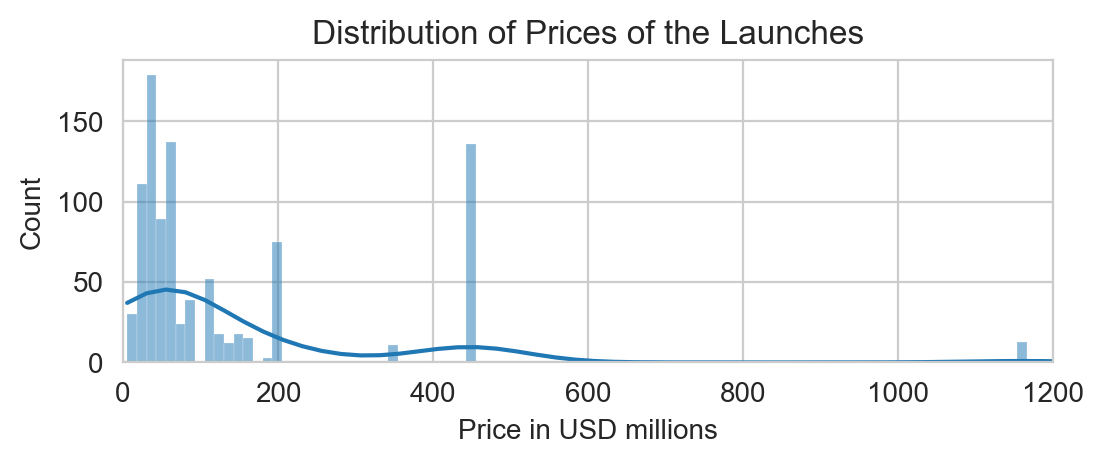

In [222]:
plt.figure(figsize=(6, 2), dpi=200)
sns.histplot(
    data=df_data_price,
    x=df_data_price.Price,
    bins=400,
    kde=True,
)
plt.xlabel("Price in USD millions")
plt.title('Distribution of Prices of the Launches')
plt.xlim([0, 1200])
plt.show()

# Choropleth Map to Show the Number of Launches by Country

In [223]:
num_launches = px.choropleth(
    locations=df_data.groupby('ISO3').count().index,
    color=df_data.groupby('ISO3').count()['Detail'],
    color_continuous_scale='matter',
)
num_launches.show()

# Choropleth Map to Show the Number of Failures by Country


In [224]:
df_fails = df_data[df_data.Mission_Status=='Failure']
df_fails.groupby('ISO3').count().sort_values('Mission_Status', ascending=False).Mission_Status

ISO3
USA    132
KAZ     72
RUS     63
CHN     19
FRA     13
JPN     10
IND      8
IRN      8
AUS      3
PRK      3
BRA      2
ISR      2
KOR      2
NZL      2
Name: Mission_Status, dtype: int64

In [225]:
num_fails = px.choropleth(
    locations=df_fails.groupby('ISO3').count().index,
    color=df_fails.groupby('ISO3').count().Detail,
    color_continuous_scale='matter',
)
num_fails.show()

# Plotly Sunburst Chart of the countries, organisations, and mission status.

In [226]:
sunburst_chart = px.sunburst(
    df_data,
    path=['ISO3', 'Organisation', 'Mission_Status'],
    title='Mission Status by Country and Organisation'
)
sunburst_chart.show()

# Total Amount of Money Spent by Organisation on Space Missions

In [227]:
df_data_price.groupby('Organisation').sum('Price').sort_values(by='Price', ascending=False)

,Price
Organisation,
NASA,"76,280.00"
Arianespace,"16,345.00"
ULA,"14,798.00"
RVSN USSR,"10,000.00"
CASC,"6,340.26"
SpaceX,"5,444.00"
Northrop,"3,930.00"
MHI,"3,532.50"
ISRO,"2,177.00"


# Amount of Money Spent by Organisation per Launch

In [228]:
print('Average Spent by Organisation per Launch')
df_data_price.groupby('Organisation').mean('Price').sort_values(by='Price', ascending=False)

Average Spent by Organisation per Launch


,Price
Organisation,
RVSN USSR,"5,000.00"
NASA,511.95
Boeing,177.29
Arianespace,170.26
ULA,151.00
ILS,101.54
MHI,95.47
Martin Marietta,80.16
US Air Force,59.65


In [229]:
sunburst_per_launch = px.sunburst(
    df_data_price,
    path=['Organisation', 'Price'],
    title='Amount of Money Spent by Organisation per Launch'
)
sunburst_per_launch.show()


# Number of Launches per Year

In [230]:
launches_per_year = df_data.groupby(df_data.Date.dt.strftime('%Y')).count().Date
launches_per_year

Date
1957      3
1958     28
1959     20
1960     39
1961     52
       ... 
2016     90
2017     92
2018    117
2019    109
2020     62
Name: Date, Length: 64, dtype: int64

In [231]:
launches_per_year_bar = px.bar(
    x=launches_per_year.index,
    y=launches_per_year.values,
    title='Launches per Year',
)
launches_per_year_bar.update_layout(xaxis_title='Year', yaxis_title='Number of Launches')
launches_per_year_bar.show()

In [232]:
max_launches = launches_per_year.max()
launches_per_year[launches_per_year.values == max_launches]

Date
1971    119
Name: Date, dtype: int64

The most active year were from 1965 to 1978 which mark the escalation of the Cold War. Apollo 11 landed on the Moon 1969. Two years later was the most active year in history.
The decline of launches from 1978 lasted up tp 2016. Now the numbers of launches rise again. Even to precious hights during the Cold War.

# Launches per Month: Which months are most popular and least popular for launches?

Which time of year seems to be best for space missions?

In [233]:
launches_per_month = df_data.groupby(df_data.Date.dt.strftime('%m')).count().Date
launches_per_month

Date
01    268
02    336
03    353
04    382
05    326
06    402
07    351
08    373
09    365
10    381
11    336
12    450
Name: Date, dtype: int64

In [234]:
launches_per_month_bar = px.bar(
    x=launches_per_month.index,
    y=launches_per_month.values,
    title='Launches per Month',
)
launches_per_month_bar.update_layout(xaxis_title='Month', yaxis_title='Number of Launches')
launches_per_month_bar.show()

It seems that December is the most popular month with 450 launches. Second is June with 402 launches. The lowest number of launches had January with only 268 launches.

# How has the Launch Price varied Over Time? 

Line chart that shows the average price of rocket launches over time.

In [235]:
avg_price = []
years = []
for year in range(1957, 2021):
    avg_price.append(df_data_price[df_data_price.Date.dt.year == year].Price.mean())
    years.append(year)

avg_years = pd.Series(data=avg_price, index=years)
# avg_years.dropna(inplace=True)

In [236]:
avg_price_plot = px.line(
    avg_years,
    x=avg_years.index,
    y=avg_years.values,
    markers=True,
    title='Average Price of Rocket Launches over Time',
)
avg_price_plot.update_layout(xaxis_title='Year', yaxis_title='Average Price of Launches')
avg_price_plot.show()

There were no recorded Prices between 1957 - 1964 and 1973 - 1981.

# Number of Launches over Time by the Top 10 Organisations.

How has the dominance of launches changed over time between the different players?

In [237]:
launches_per_org = df_data.drop(columns=['Location', 'ISO3', 'Detail', 'Rocket_Status', 'Price', 'Mission_Status'])
launches_per_org.Date = launches_per_org.Date.dt.year
organisations = launches_per_org.groupby('Organisation').count().sort_values(by='Date', ascending=False)[:10].index

In [238]:
launch_org_dict = {}
for org in organisations:
    data = launches_per_org[launches_per_org.Organisation == org].groupby('Date').count()
    launch_org_dict[org] = pd.Series(data.Organisation.values, index=data.index.values)

launch_org_df = pd.DataFrame(data=launch_org_dict)
launch_org_df

,RVSN USSR,Arianespace,CASC,General Dynamics,NASA,VKS RF,US Air Force,ULA,Boeing,Martin Marietta
1957,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958,5.00,NaN,NaN,NaN,2.00,NaN,2.00,NaN,NaN,NaN
1959,4.00,NaN,NaN,1.00,1.00,NaN,10.00,NaN,NaN,NaN
1960,9.00,NaN,NaN,5.00,4.00,NaN,21.00,NaN,NaN,NaN
1961,9.00,NaN,NaN,8.00,12.00,NaN,23.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016,NaN,11.00,22.00,NaN,NaN,4.00,NaN,12.00,NaN,NaN
2017,NaN,11.00,16.00,NaN,NaN,6.00,NaN,8.00,NaN,NaN
2018,NaN,11.00,37.00,NaN,NaN,5.00,NaN,8.00,NaN,NaN
2019,NaN,9.00,27.00,NaN,NaN,8.00,NaN,5.00,NaN,NaN


<AxesSubplot:title={'center':'Number of Launches over Time by the Top 10 Organisations'}, xlabel='Years', ylabel='Number of Launches'>

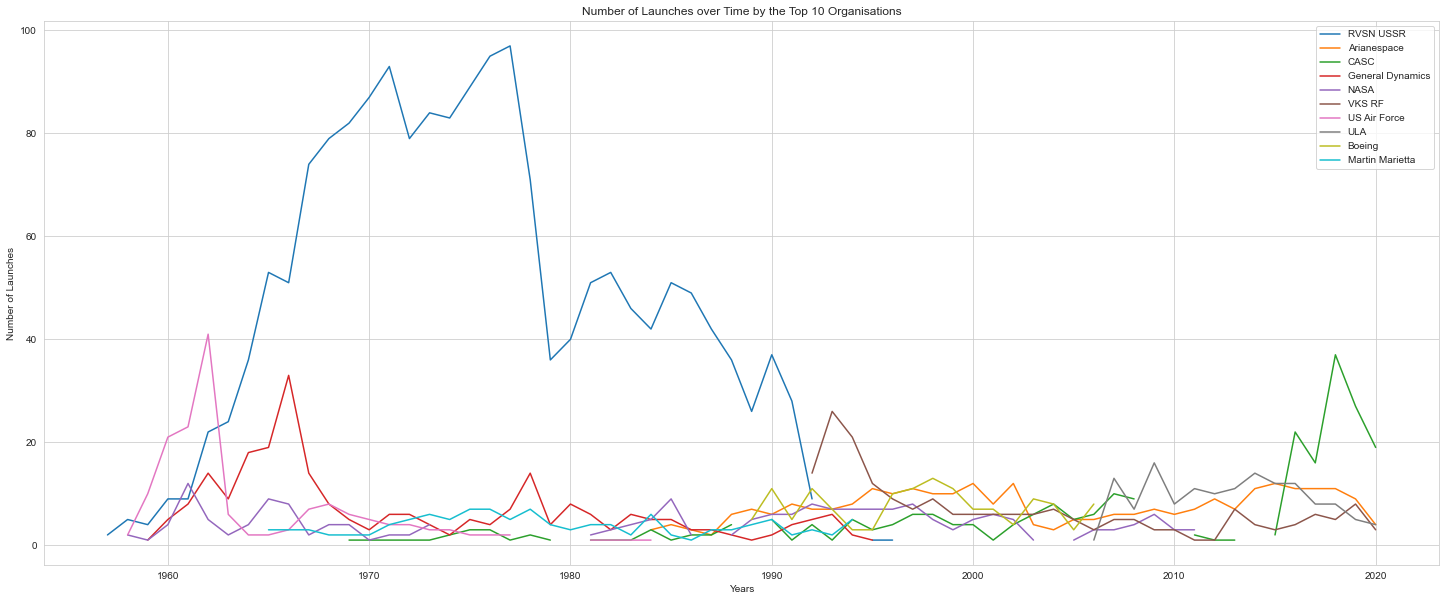

In [288]:
launch_org_df.plot(
    title='Number of Launches over Time by the Top 10 Organisations',
    figsize=(25,10),
    xlabel='Years',
    ylabel='Number of Launches',
)

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. (12 March 1947 - 26 December 1991)

In [260]:
space_race_df = df_data[df_data.Date.dt.date < datetime.date(1991, 12, 26)]
ussr_df = space_race_df[space_race_df.Organisation == 'RVSN USSR']
usa_df = space_race_df[space_race_df.ISO3 == 'USA']

*The USSR data is selected by Organisation because some Launches were also in Kazakhstan which was part of the Soviet Union.
The American data will be selected by Country to cover all American Organisations.*

## Total number of launches of the USSR and the USA

In [261]:
print(f'Total number of Launches USA: {usa_df.Date.count()}')

Total number of Launches USA: 662


In [262]:
print(f'Total number of Launches USSR: {ussr_df.Date.count()}')

Total number of Launches USSR: 1765


## Total Number of Launches Year-On-Year by the Two Superpowers

In [263]:
ussr_df.Date = ussr_df.Date.dt.year
usa_df.Date = usa_df.Date.dt.year

/var/folders/02/fzh7rm1909q5tqfhd0ymh5hr0000gn/T/ipykernel_77038/3279190891.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/02/fzh7rm1909q5tqfhd0ymh5hr0000gn/T/ipykernel_77038/3279190891.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [281]:
ussr_yearly_df = ussr_df.groupby('Date').count().Location
ussr_yearly_series = pd.Series(data=ussr_yearly_df.values, index=ussr_yearly_df.index)

usa_yearly_df = usa_df.groupby('Date').count().Location
usa_yearly_series = pd.Series(data=usa_yearly_df.values, index=usa_yearly_df.index)

yearly_space_race_launches = pd.DataFrame(
    data={
        'USSR': ussr_yearly_series,
        'USA': usa_yearly_series,
    }
)
yearly_space_race_launches.head()

,USSR,USA
Date,,
1957,2,1
1958,5,23
1959,4,16
1960,9,30
1961,9,43


<AxesSubplot:title={'center':'Number of Launches during the Space Race by the Two Superpowers'}, xlabel='Years', ylabel='Number of Launches'>

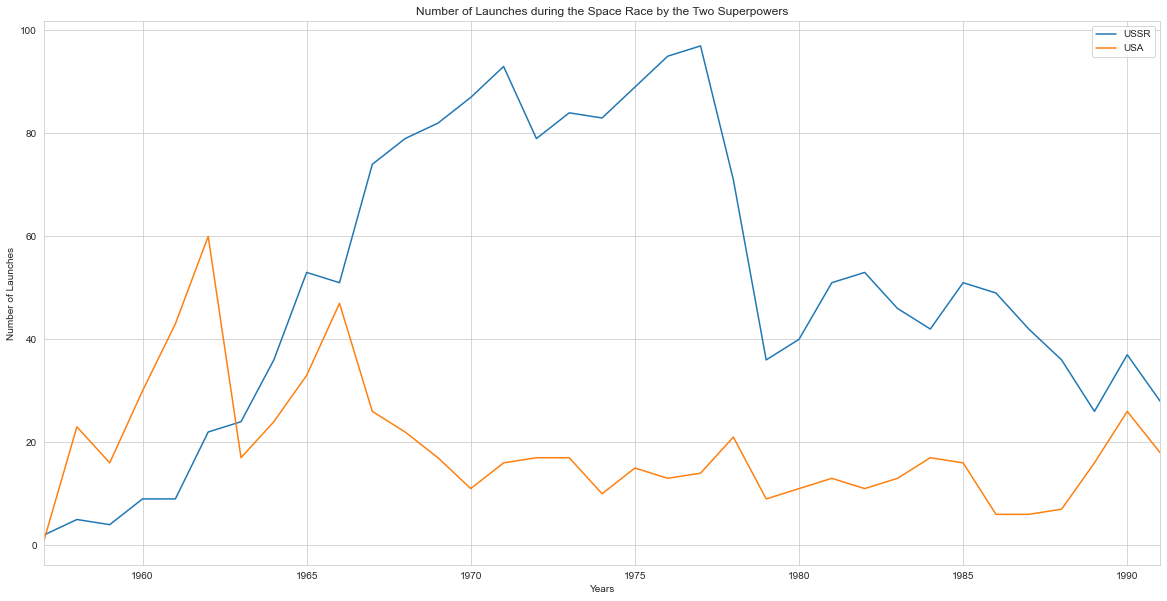

In [291]:
yearly_space_race_launches.plot(
    title='Number of Launches during the Space Race by the Two Superpowers',
    figsize=(20,10),
    xlabel='Years',
    ylabel='Number of Launches',
    xlim=[1957, 1991],
)

## Total Number of Mission Failures Year on Year.

## Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time? 

# Which Country was in the Lead in terms of Total Number of Launches up to and including 2020?

Do the results change if we only look at the number of successful launches? 

# Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020? 